In [3]:
# coding: utf-8
import numpy as np
import math

class SGD:

    """ Stochastic Gradient Descent """

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """ Momentum SGD """

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """ Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901) """

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]


class AdaGrad:

    """ AdaGrad """

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """ RMSprop """

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8) """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, correct=True):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        self.correct = correct
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            # self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            # self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            hat_m = self.m[key] / (1 - self.beta1 ** self.iter)
            hat_v = self.v[key] / (1 - self.beta2 ** self.iter)
            
            if self.correct:
                params[key] -= lr_t * hat_m / (np.sqrt(hat_v) + 1e-7)
            else:
                params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

In [15]:
def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-3.5, 2.1)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

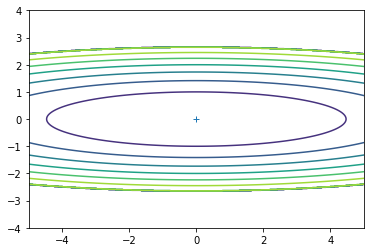

In [22]:
x = np.arange(-10, 10, 0.01)
y = np.arange(-10, 10, 0.01)

X, Y = np.meshgrid(x, y) 
Z = f(X, Y)

# for simple contour line  
mask = Z > 7
Z[mask] = 0

# plot
plt.subplot(1, 1, idx)
plt.contour(X, Y, Z)
plt.ylim(-4, 4)
plt.xlim(-5, 5)
plt.plot(0, 0, '+')
plt.show()

In [23]:
optimizers = OrderedDict()
""" intros """
# optimizers["SGD_lr=0.9"] = SGD(lr=0.9)
optimizers["SGD"] = SGD(lr=0.1)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["Nesterov"] = Nesterov(lr=0.1)
optimizers["RMSprop"] = RMSprop(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=0.1)
optimizers["Adam"] = Adam(lr=0.1, correct=False)

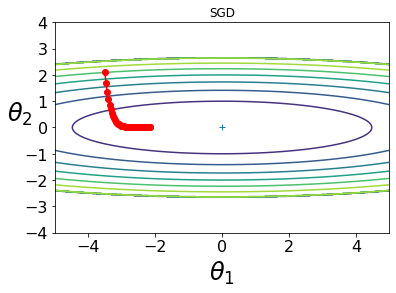

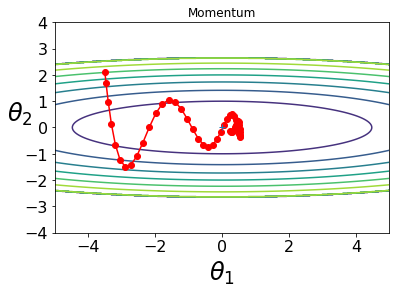

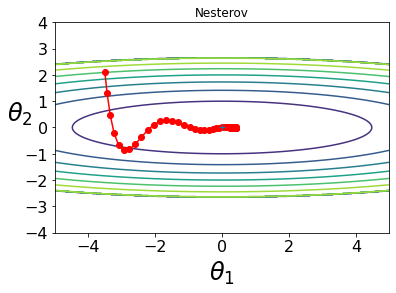

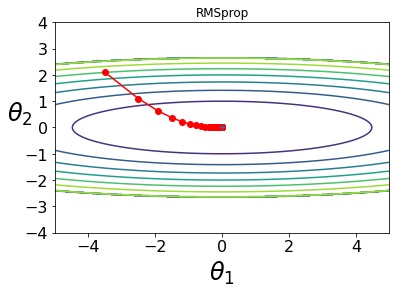

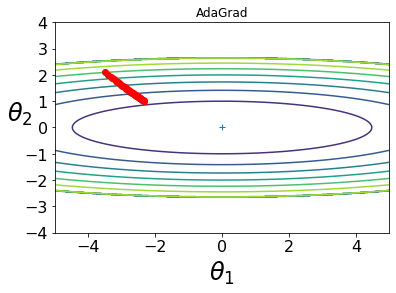

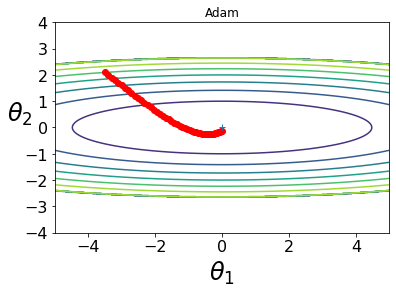

In [24]:
idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(50):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-10, 10, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)

    df_history = pd.DataFrame(x_history, columns=['x'])
    df_history['y'] = pd.DataFrame(y_history)
    df_history.to_csv('logs/{opt}'.format(opt=key), sep=' ', header=False, index=False)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot
    plt.subplot(1, 1, idx)
    # idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    # plt.plot(x_history, y_history, 'o-', label=key)
    plt.contour(X, Y, Z)
    plt.ylim(-4, 4)
    plt.xlim(-5, 5)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    # plt.title(key)
    # plt.legend()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(r"$\theta_{1}$", fontsize=24)
    plt.ylabel(r"$\theta_{2}$", fontsize=24, rotation=0)
    plt.title("{key}".format(key=key))



    plt.gcf().subplots_adjust(bottom=0.15) # adjust xlabel
#     plt.savefig("trajectory/{key}.pdf".format(key=key), 
#             dpi=None, 
#             facecolor='w', 
#             edgecolor='w',
#             orientation='portrait', 
#             papertype=None, 
#             format=None,
#             transparent=False, 
#             bbox_inches=None, 
#             pad_inches=0.1,
#             frameon=None, 
#             metadata=None)

#     plt.clf()

    plt.show()